<a href="https://colab.research.google.com/github/sonwh123/Deep-Learning/blob/master/model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fashion MINIST dataset

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.6 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
import numpy as np
from torch.nn.parameter import Parameter
from torch.optim import Adam
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, BatchNorm2d, NLLLoss
from torch import cat
import torch.nn as nn
import torch.nn.init as init
import pennylane as qml, torch
from tqdm import tqdm
from datetime import datetime
from google.colab import files

In [3]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)



train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

binary_train_ds = Subset(train_ds, train_idx)



train_loader = DataLoader(binary_train_ds, batch_size = 64, shuffle =True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


### 모델 설계

In [42]:

torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5)
        self.bn1 = BatchNorm2d(8)
        self.conv2 = Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(8)
        self.conv3 = Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn3 = BatchNorm2d(16)
        self.dropout1 = Dropout2d()
        self.dropout2 = Dropout2d()
        self.fc1 = Linear(16*3*3, 256)
        self.fc2 = Linear(4, 1)

        # Quantum layer
        self.q_device = qml.device("default.qubit", wires=8)

        # 가중치 랜덤
        self.qnn_params = Parameter(torch.rand(40), requires_grad= True)
        # # 가중치 초기화
        # init_range = torch.pi / 4
        # init_weights = torch.empty(40).uniform_(-init_range, init_range)
        # self.qnn_params = Parameter(init_weights, requires_grad=True)

        # self.obs = qml.PauliZ(7)

        @qml.qnode(self.q_device)
        def circuit(inputs, weights):
            # ✅ Feature Encoding: Amplitude Encoding
            qml.AmplitudeEmbedding(inputs[:], wires=range(8), normalize=True)

            #---------------
            #Convolution
            for idx, (w0, w1) in enumerate([(0,1), (2,3), (4,5), (6,7)]):
              qml.RZ(-np.pi/2, wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(self.qnn_params[0+idx*3], wires=w0)
              qml.RY(self.qnn_params[1+idx*3], wires=w1)
              qml.CNOT(wires=[w0, w1])
              qml.RY(self.qnn_params[2+idx*3], wires=w1)
              qml.CNOT(wires=[w1, w0])
              # qml.RZ(np.pi/2, wires=w0)

            #---------------
            #Convolution
            for idx, (w0, w1) in enumerate([(1,2), (3,4), (5,6), (7,0)]):
              qml.RZ(-np.pi/2, wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(self.qnn_params[12+idx*3], wires=w0)
              qml.RY(self.qnn_params[13+idx*3], wires=w1)
              qml.CNOT(wires=[w0, w1])
              qml.RY(self.qnn_params[14+idx*3], wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(np.pi/2, wires=w0)

            #---------------
            #Pooling
            for idx, (w0, w1) in enumerate([(0,1), (2,3), (4,5), (6,7)]):
              qml.CNOT(wires=[w0, w1])        # w0 → w1 얽힘
              qml.RY(self.qnn_params[24+idx], wires=w1)         # w1 회전 (파라미터 적용)
              qml.CNOT(wires=[w1, w0])        # 다시 w1 → w0 얽힘 제거

            #---------------
            #Convolution
            for idx, (w0, w1) in enumerate([(0,2), (4,6)]):
              qml.RZ(-np.pi/2, wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(self.qnn_params[28+idx*3], wires=w0)
              qml.RY(self.qnn_params[29+idx*3], wires=w1)
              qml.CNOT(wires=[w0, w1])
              qml.RY(self.qnn_params[30+idx*3], wires=w1)
              qml.CNOT(wires=[w1, w0])
              # qml.RZ(np.pi/2, wires=w0)

            #---------------
            #Convolution
            for idx, (w0, w1) in enumerate([(2,4), (6,0)]):
              qml.RZ(-np.pi/2, wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(self.qnn_params[34+idx*3], wires=w0)
              qml.RY(self.qnn_params[35+idx*3], wires=w1)
              qml.CNOT(wires=[w0, w1])
              qml.RY(self.qnn_params[36+idx*3], wires=w1)
              qml.CNOT(wires=[w1, w0])
              qml.RZ(np.pi/2, wires=w0)

            return [qml.expval(qml.PauliZ(2*i)) for i in range(4)]

        self.qnn = qml.qnn.TorchLayer(circuit, {"weights": self.qnn_params.shape[0]})

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(-1,16*3*3)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.qnn(x)
        x = self.fc2(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

In [43]:
bc = BinaryClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=144, out_features=256, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (qnn): <Quantum Torch Layer: func=circuit>
)

In [44]:
# prompt: bc의 전체 학습 가중치 파라미터 개수를 알라보려면? 영어로 출력

total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 39229


In [50]:
# ───── 학습 전에 회로 제약 먼저 점검 ─────
dummy_x = torch.tensor(torch.rand(2,256), dtype=torch.float64)
specs = qml.specs(bc.qnn)(dummy_x)

/tmp/ipython-input-50-2798777044.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dummy_x = torch.tensor(torch.rand(2,256), dtype=torch.float64)


0: ─╭|Ψ⟩────────────╭X──RZ(0.95)─╭●───────────╭X──RZ(-1.57)───────────────────────────── ···
1: ─├|Ψ⟩──RZ(-1.57)─╰●──RY(0.55)─╰X──RY(0.88)─╰●────────────╭X──RZ(0.90)─╭●───────────╭X ···
2: ─├|Ψ⟩────────────╭X──RZ(0.49)─╭●───────────╭X──RZ(-1.57)─╰●──RY(0.07)─╰X──RY(0.30)─╰● ···
3: ─├|Ψ⟩──RZ(-1.57)─╰●──RY(0.66)─╰X──RY(0.24)─╰●────────────╭X──RZ(0.89)─╭●───────────╭X ···
4: ─├|Ψ⟩────────────╭X──RZ(0.20)─╭●───────────╭X──RZ(-1.57)─╰●──RY(0.95)─╰X──RY(1.00)─╰● ···
5: ─├|Ψ⟩──RZ(-1.57)─╰●──RY(0.56)─╰X──RY(0.79)─╰●────────────╭X──RZ(0.86)─╭●───────────╭X ···
6: ─├|Ψ⟩────────────╭X──RZ(0.57)─╭●───────────╭X──RZ(-1.57)─╰●──RY(0.38)─╰X──RY(0.21)─╰● ···
7: ─╰|Ψ⟩──RZ(-1.57)─╰●──RY(0.80)─╰X──RY(0.60)─╰●──────────────────────────────────────── ···

0: ··· ───────────╭●──RY(0.61)─╭X──RY(0.78)─╭●─╭●──────────────────╭X────────────────── ···
1: ··· ──RZ(1.57)─│────────────│────────────│──╰X─────────RY(0.47)─╰●────────────────── ···
2: ··· ───────────│────────────│────────────│──╭●──────────────────╭X──

(<Figure size 4500x900 with 1 Axes>, <Axes: >)

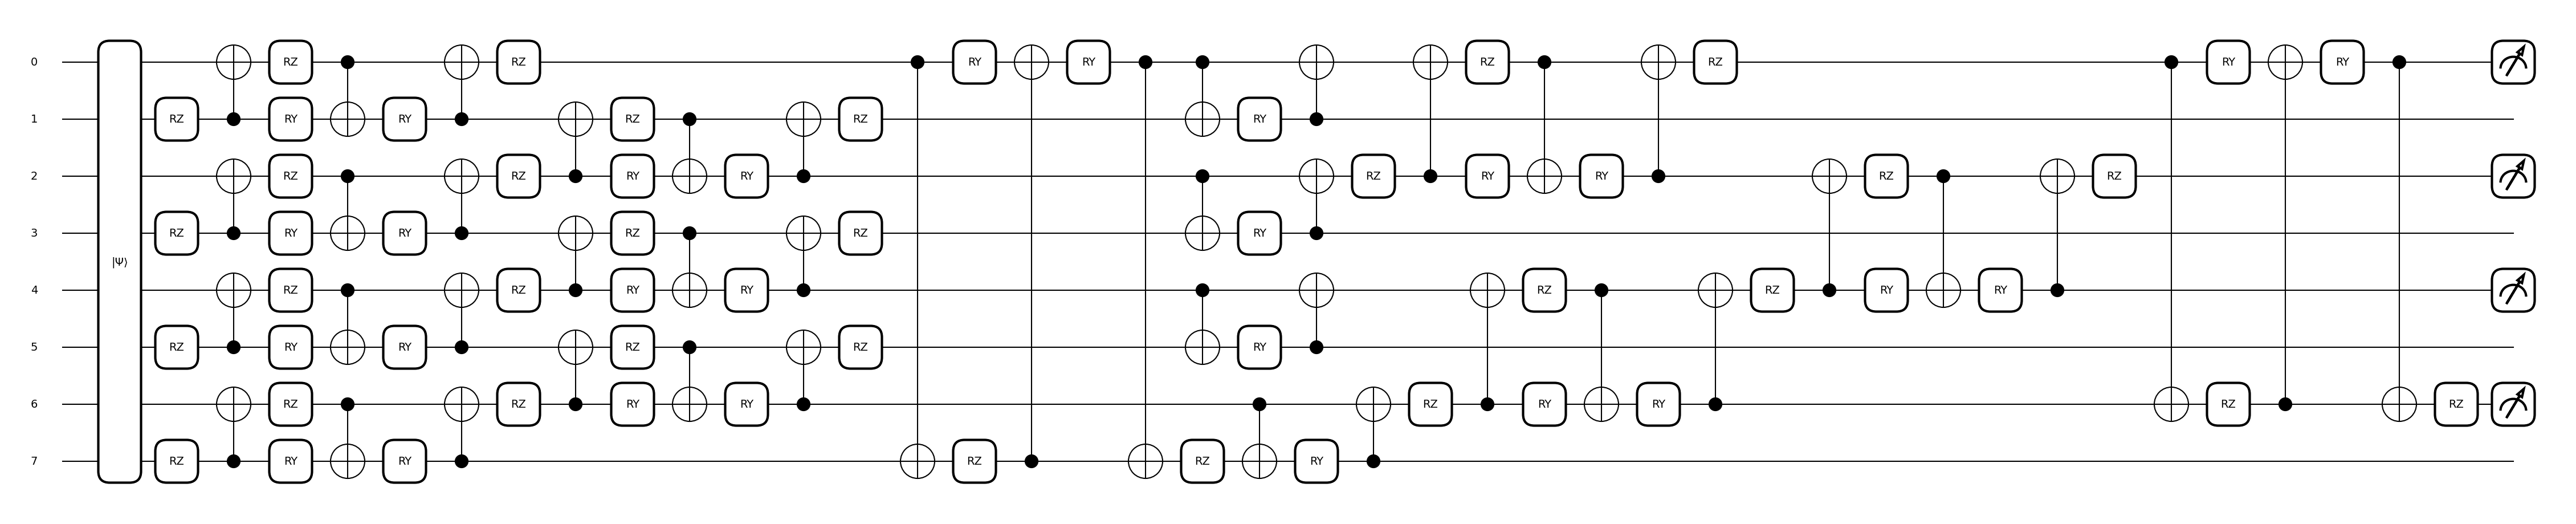

In [51]:
print(qml.draw(bc.qnn)(dummy_x))
qml.draw_mpl(bc.qnn)(dummy_x)

In [52]:
specs

{'resources': Resources(num_wires=8, num_gates=103, gate_types=defaultdict(<class 'int'>, {'AmplitudeEmbedding': 1, 'RZ': 30, 'CNOT': 44, 'RY': 28}), gate_sizes=defaultdict(<class 'int'>, {8: 1, 1: 58, 2: 44}), depth=30, shots=Shots(total_shots=None, shot_vector=())),
 'errors': {},
 'num_observables': 4,
 'num_trainable_params': 40,
 'num_device_wires': 8,
 'num_tape_wires': 8,
 'device_name': 'default.qubit',
 'level': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [53]:
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

✅ 회로 제약 통과 — 학습을 계속합니다


In [54]:
data, target = next(iter(train_loader))

In [55]:
# optimizer = torch.optim.AdamW(bc.parameters(), lr=0.00001)
optimizer = torch.optim.AdamW(bc.parameters(), lr=1e-3, weight_decay=1e-5)

loss_func  = NLLLoss()

loss_history = []
bc.train()

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=144, out_features=256, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (qnn): <Quantum Torch Layer: func=circuit>
)

### 함수 정의

**초기 학습**

In [56]:
def just_training(theta):
  clear_output(wait=True)
  epoch_bar = tqdm(range(len(train_loader)),
                  desc=f"Epoch (just training)",
                  leave=False)   # leave=False면 다음 에폭 때 덮어씀

  total_loss = []
  for bidx, (data, target) in zip(epoch_bar, train_loader):
      optimizer.zero_grad(set_to_none=True)
      data, target = data.to(device), target.to(device)
      output = bc(data)
      loss   = loss_func(output, target.squeeze())

      total_loss.append(loss.item())
      loss.backward()
      optimizer.step()

      # 50배치마다 postfix로 현재 상태 표시
      if bidx % 50 == 0:
          epoch_bar.set_postfix(batch=bidx,
                                loss=f"{loss.item():.4f}")

  # 에폭 끝나면 전체 loss 기록
  avg_loss = sum(total_loss) / len(total_loss)
  loss_history.append(avg_loss)

  # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
  print(f"Training "
        f"Loss: {avg_loss:.4f}")

  if avg_loss >= theta:
    return just_training(theta)
  else:
    return

**학습 시작**

In [57]:
def training(epochs):
  for epoch in range(epochs):
        # 에폭 진행률 바
        epoch_bar = tqdm(range(len(train_loader)),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        leave=False)   # leave=False면 다음 에폭 때 덮어씀

        total_loss = []
        for bidx, (data, target) in zip(epoch_bar, train_loader):
            optimizer.zero_grad(set_to_none=True)
            data, target = data.to(device), target.to(device)
            output = bc(data)
            loss   = loss_func(output, target.squeeze())

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()

            # 50배치마다 postfix로 현재 상태 표시
            if bidx % 50 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                      loss=f"{loss.item():.4f}")

        # 에폭 끝나면 전체 loss 기록
        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
              f"Loss: {avg_loss:.4f}")
  return avg_loss

**추론 및 평가**

In [58]:
def inference_evaluation(iteration_history, iterations, avg_loss):
  ### 모델 추론
  test_loader = DataLoader(
      test_ds,
      batch_size=1,
      shuffle=False
  )

  # bc.eval()

  all_preds, all_targets = [], []

  with torch.no_grad():
      for data, target in tqdm(test_loader,
                              desc="Inference",
                              total=len(test_loader),
                              leave=False):
          data, target = data.to(device), target.to(device)

          logits = bc(data)

          pred = logits.argmax().view(1)

          all_preds.append(pred.cpu())
          all_targets.append(target.view(-1).cpu())

  y_pred = torch.cat(all_preds).numpy().astype(int)
  y_true = torch.cat(all_targets).numpy().astype(int)

  ### 평가
  # 0·6 라벨만 평가
  test_mask = (y_true == 0) | (y_true == 6)

  # 모델 결과가 1인 것을 6으로 변경
  y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

  acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
  iteration_history.append([avg_loss, acc])
  clear_output(wait=True)
  for i in range(len(iteration_history)):
    print(f"Iteration [{i+1}/{iterations}], "
          f"Loss: {iteration_history[i][0]:.4f}, "
          f"Accuracy: {iteration_history[i][1]:.4f}")
  return y_pred_mapped

**파라미터 및 결과 저장**

In [59]:
def save_file(y_pred_mapped):
  # 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
  now = datetime.now().strftime("%Y%m%d_%H%M%S")

  # 원본 파일명을 기반으로 새 파일명 생성
  y_pred_filename = f"y_pred_{now}.csv"

  np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
  torch.save(bc.state_dict(), f"params_{now}.pth")

# 학습 시작

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc.to(device)
epochs = 3
iterations = 15
iteration_history = []
theta = 0.35

bc.train()
just_training(theta)
for _ in range(iterations):
  bc.train()
  avg_loss = training(epochs)
  bc.eval()
  y_pred_mapped = inference_evaluation(iteration_history, iterations, avg_loss)
  save_file(y_pred_mapped)

Epoch (just training):   0%|          | 0/188 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch (just training):  72%|███████▏  | 135/188 [00:29<00:14,  3.76it/s, batch=100, loss=0.6204]

# 원본

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc.to(device)
epochs = 2
iterations = 15
iteration_history = []
theta = 0.4

### theta까지는 학습만
while True:
  clear_output(wait=True)
  epoch_bar = tqdm(range(len(train_loader)),
                  desc=f"Epoch (just training)",
                  leave=False)   # leave=False면 다음 에폭 때 덮어씀

  total_loss = []
  for bidx, (data, target) in zip(epoch_bar, train_loader):
      optimizer.zero_grad(set_to_none=True)
      data, target = data.to(device), target.to(device)
      output = bc(data)
      loss   = loss_func(output, target.squeeze())

      total_loss.append(loss.item())
      loss.backward()
      optimizer.step()

      # 100배치마다 postfix로 현재 상태 표시
      if bidx % 100 == 0:
          epoch_bar.set_postfix(batch=bidx,
                                loss=f"{loss.item():.4f}")

  # 에폭 끝나면 전체 loss 기록
  avg_loss = sum(total_loss) / len(total_loss)
  loss_history.append(avg_loss)

  # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
  print(f"Training "
        f"Loss: {avg_loss:.4f}")

  if avg_loss < theta:
    break

### 학습 및 평가
for iteration in range(iterations):
  for epoch in range(epochs):
      # 에폭 진행률 바
      epoch_bar = tqdm(range(len(train_loader)),
                      desc=f"Epoch {epoch+1}/{epochs}",
                      leave=False)   # leave=False면 다음 에폭 때 덮어씀

      total_loss = []
      for bidx, (data, target) in zip(epoch_bar, train_loader):
          optimizer.zero_grad(set_to_none=True)
          data, target = data.to(device), target.to(device)
          output = bc(data)
          loss   = loss_func(output, target.squeeze())

          total_loss.append(loss.item())
          loss.backward()
          optimizer.step()

          # 100배치마다 postfix로 현재 상태 표시
          if bidx % 100 == 0:
              epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}")

      # 에폭 끝나면 전체 loss 기록
      avg_loss = sum(total_loss) / len(total_loss)
      loss_history.append(avg_loss)

      # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
      print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
            f"Loss: {avg_loss:.4f}")



  ### 모델 추론
  test_loader = DataLoader(
      test_ds,
      batch_size=1,
      shuffle=False
  )

  bc.eval()

  all_preds, all_targets = [], []

  with torch.no_grad():
      for data, target in tqdm(test_loader,
                              desc="Inference",
                              total=len(test_loader),
                              leave=False):
          data, target = data.to(device), target.to(device)

          logits = bc(data)

          pred = logits.argmax().view(1)

          all_preds.append(pred.cpu())
          all_targets.append(target.view(-1).cpu())

  y_pred = torch.cat(all_preds).numpy().astype(int)
  y_true = torch.cat(all_targets).numpy().astype(int)

  ### 평가 및 결과 저장
  # 0·6 라벨만 평가
  test_mask = (y_true == 0) | (y_true == 6)

  # print("total samples:", len(y_true))
  # print("target samples:", test_mask.sum())

  # 모델 결과가 1인 것을 6으로 변경
  y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

  acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
  iteration_history.append([avg_loss, acc])
  clear_output(wait=True)
  for i in range(len(iteration_history)):
    print(f"Iteration [{i+1}/{iterations}], "
          f"Loss: {iteration_history[i][0]:.4f}, "
          f"Accuracy: {iteration_history[i][1]:.4f}")


  # 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
  now = datetime.now().strftime("%Y%m%d_%H%M%S")

  # 원본 파일명을 기반으로 새 파일명 생성
  y_pred_filename = f"y_pred_{now}.csv"

  np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
  torch.save(bc.state_dict(), f"params_{now}.pth")

Iteration [1/15], Loss: 0.2828, Accuracy: 0.8890
Iteration [2/15], Loss: 0.2125, Accuracy: 0.8945
Iteration [3/15], Loss: 0.1999, Accuracy: 0.8895
Iteration [4/15], Loss: 0.1895, Accuracy: 0.8935
Iteration [5/15], Loss: 0.1795, Accuracy: 0.8950
Iteration [6/15], Loss: 0.1701, Accuracy: 0.8900
Iteration [7/15], Loss: 0.1617, Accuracy: 0.8840
Iteration [8/15], Loss: 0.1523, Accuracy: 0.8930


KeyboardInterrupt: 

In [ ]:
print(f"first loss: {loss_history[0]}, last loss: {loss_history[-1]}")

first loss: 0.38608683473807115, last loss: 0.12215304431180682


# ...

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc.to(device)
epochs = 5

for epoch in range(epochs):
    # 에폭 진행률 바
    epoch_bar = tqdm(range(len(train_loader)),
                     desc=f"Epoch {epoch+1}/{epochs}",
                     leave=False)   # leave=False면 다음 에폭 때 덮어씀

    total_loss = []
    for bidx, (data, target) in zip(epoch_bar, train_loader):
        optimizer.zero_grad(set_to_none=True)
        data, target = data.to(device), target.to(device)
        output = bc(data)
        loss   = loss_func(output, target.squeeze())

        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # 100배치마다 postfix로 현재 상태 표시
        if bidx % 100 == 0:
            epoch_bar.set_postfix(batch=bidx,
                                  loss=f"{loss.item():.4f}")

    # 에폭 끝나면 전체 loss 기록
    avg_loss = sum(total_loss) / len(total_loss)
    loss_history.append(avg_loss)

    #loss history 그리기
    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, marker='o')
    plt.title("Training Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    # 에폭 요약 한 줄 출력 (leave=False였으면 이게 마지막 줄로 남음)
    print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
          f"Loss: {avg_loss:.4f}")


# 모델 추론

In [ ]:
from datetime import datetime

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False
)

bc.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for data, target in tqdm(test_loader,
                             desc="Inference",
                             total=len(test_loader),
                             leave=False):
        data, target = data.to(device), target.to(device)

        logits = bc(data)

        pred = logits.argmax().view(1)

        all_preds.append(pred.cpu())
        all_targets.append(target.view(-1).cpu())

y_pred = torch.cat(all_preds).numpy().astype(int)
y_true = torch.cat(all_targets).numpy().astype(int)

 # 평가 및 결과 저장

In [ ]:
# 0·6 라벨만 평가
test_mask = (y_true == 0) | (y_true == 6)

print("total samples:", len(y_true))
print("target samples:", test_mask.sum())

# 모델 결과가 1인 것을 6으로 변경
y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
print(f"accuracy (labels 0/6 only): {acc:.4f}")

total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8980


In [ ]:
# 0·6 라벨만 평가
test_mask = (y_true == 0) | (y_true == 6)

print("total samples:", len(y_true))
print("target samples:", test_mask.sum())

# 모델 결과가 1인 것을 6으로 변경
y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
print(f"accuracy (labels 0/6 only): {acc:.4f}")

# 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
now = datetime.now().strftime("%Y%m%d_%H%M%S")

# 원본 파일명을 기반으로 새 파일명 생성
y_pred_filename = f"y_pred_{now}.csv"

np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")

# 모델 추론 결과 파일 다운로드

자동으로 다운로드되는 파일을 [제출하기](https://aifactory.space/task/9154/submit) 페이지에 업로드하면 자동으로 채점이 되며 정상적으로 채점이 된다면 리더보드에서 자기점수를 확인할 수 있습니다.


In [ ]:
from google.colab import files

files.download(y_pred_filename)

NameError: name 'y_pred_filename' is not defined

# 파라미터 추출

In [ ]:
torch.save(bc.state_dict(), "params.pth")
files.download("params.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 파라미터 확인

In [ ]:
for name, param in bc.named_parameters():
    print(f"{name}: {param.data}")
    bc.eval()

qnn_params: tensor([0.5861, 0.4568, 0.1755, 0.9701, 0.8020, 0.6269, 0.8943, 0.9922, 0.8712])
conv1.weight: tensor([[[[ 0.1407,  0.0609, -0.1728, -0.1761,  0.0667],
          [ 0.0717, -0.0808, -0.0857,  0.0267, -0.0727],
          [ 0.0196, -0.0952,  0.1811,  0.0529, -0.1085],
          [ 0.0120, -0.1403,  0.0304,  0.1115,  0.1005],
          [-0.1966,  0.1402,  0.0201, -0.1746, -0.0922]]],


        [[[ 0.0971, -0.0719, -0.0328, -0.0382,  0.0592],
          [-0.0400, -0.0779,  0.1097,  0.0333,  0.0948],
          [ 0.1881, -0.0689, -0.0837, -0.1984,  0.1251],
          [ 0.0620, -0.0613, -0.1076, -0.1109,  0.0899],
          [-0.1776,  0.0504,  0.0653,  0.1338, -0.1828]]]])
conv1.bias: tensor([0.1327, 0.0484])
conv2.weight: tensor([[[[ 0.0767,  0.1268,  0.0768,  0.0626, -0.1413],
          [-0.0545, -0.0606,  0.1099,  0.0244,  0.1207],
          [ 0.0997,  0.0330,  0.1036,  0.0979,  0.0961],
          [ 0.0945,  0.0265, -0.0625, -0.1392, -0.1087],
          [-0.0674,  0.1338,  0.1266,

# 파라미터 로딩

In [ ]:
from google.colab import files

In [ ]:
## CPU일 때
state_dict = torch.load("8985.pth", map_location='cpu')
bc.load_state_dict(state_dict)
print("모델이 CPU로 성공적으로 로드되고 bc 인스턴스에 적용되었습니다.")

모델이 CPU로 성공적으로 로드되고 bc 인스턴스에 적용되었습니다.


In [ ]:
## GPU일 때
state_dict = torch.load("8985.pth")
bc.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for BinaryClassifier:
	size mismatch for fc2.weight: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([1, 8]).